# NLP

In [20]:
import pandas as pd
import regex as re
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from pickle import dump
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")


### Step 1: Upload Data

In [21]:
url = 'https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv'
total_data = pd.read_csv(url, sep=',')
total_data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


### Step 2: Preprocess the links

***Categorical to numerical transformation***


In [22]:
total_data["is_spam"] = total_data["is_spam"].apply(lambda x: 1 if x == True else 0).astype(int)
total_data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


***Elimination of repeated values***

In [23]:
print(total_data.shape)
print(f"Spam: {len(total_data.loc[total_data.is_spam == 1])}")
print(f"No spam: {len(total_data.loc[total_data.is_spam == 0])}")

(2999, 2)
Spam: 696
No spam: 2303


In [24]:
total_data = total_data.drop_duplicates()
total_data = total_data.reset_index(inplace = False, drop = True)
total_data.shape

(2369, 2)

***Text processing***

In [25]:
def preprocess_text(text):
    # Remove any character that is not a letter (a-z) or white space ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Remove white spaces
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Multiple white spaces into one
    text = re.sub(r'\s+', " ", text.lower())

    # Remove tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

total_data["url"] = total_data["url"].apply(preprocess_text)
total_data.head()

,url,is_spam
0,"[https, briefingday, us, list, manage, com, un...",1
1,"[https, www, hvper, com]",1
2,"[https, briefingday, com, v, i]",1
3,"[https, briefingday, com, m, commentform]",0
4,"[https, briefingday, com, fan]",1


***lemmatization & Stopwords***

In [26]:
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

total_data["url"] = total_data["url"].apply(lemmatize_text)
total_data.head()

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,url,is_spam
0,"[http, briefingday, list, manage, unsubscribe]",1
1,"[http, hvper]",1
2,"[http, briefingday]",1
3,"[http, briefingday, commentform]",0
4,"[http, briefingday]",1


***word cloud***

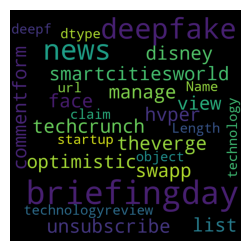

In [27]:
wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(total_data["url"]))

fig = plt.figure(figsize = (5, 3), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

***convert it into numbers***

In [28]:
tokens_list = total_data["url"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = total_data["is_spam"]

X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

***Train test split***

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Step 3: Build an SVM

In [30]:
model = SVC(kernel = "linear", random_state = 42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [31]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [32]:
accuracy_score(y_test, y_pred)

0.9514767932489452

In [33]:
y_pred_train = model.predict(X_train)
y_pred_train

array([0, 0, 0, ..., 0, 0, 0])

In [34]:
accuracy_score(y_train, y_pred_train)

0.9372031662269129

### Step 4: Optimize the previous model

***Randomized Search***

In [35]:
hyperparams = {
    "C": np.linspace(0, 5, 100),
    "kernel" : ['linear', 'poly', 'rbf', 'sigmoid'],
    "gamma": ["scale", "auto"],
    "degree": np.arange(1, 200, 4)
}

random_search = RandomizedSearchCV(model, hyperparams, n_iter = 100, scoring = "accuracy", cv = 5, random_state = 42)
random_search

RandomizedSearchCV(cv=5, estimator=SVC(kernel='linear', random_state=42),
                   n_iter=100,
                   param_distributions={'C': array([0.        , 0.05050505, 0.1010101 , 0.15151515, 0.2020202 ,
       0.25252525, 0.3030303 , 0.35353535, 0.4040404 , 0.45454545,
       0.50505051, 0.55555556, 0.60606061, 0.65656566, 0.70707071,
       0.75757576, 0.80808081, 0.85858586, 0.90909091, 0.95959596,
       1.01010101, 1.06060606, 1.1111...
       4.54545455, 4.5959596 , 4.64646465, 4.6969697 , 4.74747475,
       4.7979798 , 4.84848485, 4.8989899 , 4.94949495, 5.        ]),
                                        'degree': array([  1,   5,   9,  13,  17,  21,  25,  29,  33,  37,  41,  45,  49,
        53,  57,  61,  65,  69,  73,  77,  81,  85,  89,  93,  97, 101,
       105, 109, 113, 117, 121, 125, 129, 133, 137, 141, 145, 149, 153,
       157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197]),
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   random_state=42, scoring='accuracy')

In [36]:
random_search.fit(X_train, y_train)

print(f"Mejores hiperparámetros: {random_search.best_estimator_}")

Mejores hiperparámetros: SVC(C=2.1717171717171717, degree=185, kernel='linear', random_state=42)


In [37]:
model_random_search = SVC(C=2.1717171717171717, degree=185, kernel='linear', random_state=42)
model_random_search.fit(X_train, y_train)
y_pred = model_random_search.predict(X_test)

random_search_accuracy = accuracy_score(y_test, y_pred)
random_search_accuracy

0.959915611814346

### Step 5: Save the model

In [38]:
dump(model_random_search, open("/workspaces/JLL_NLP/models/svm_classifier_random.sav", "wb"))